In [503]:
##############################
# Author: Jacob van de Lindt
# Date:   May 22, 2023
# MIT PSFC
##############################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
from matplotlib import ticker, cm 
import os, sys
import netCDF4

In [504]:
# Setting up the paths to the local directory
# abspath = os.path.abspath('')
# dname = os.path.dirname(abspath)
# print(abspath)
# os.chdir(dname)
wkdir = os.getcwdb()


In [505]:
# Loading up the netcdf4 datasets
remoteDirectory = open(f'../remoteDirectory.txt', 'r').readlines()[0].strip()
shotNum = remoteDirectory.split('/')[-1].split('_')[1]
cql_nc = netCDF4.Dataset(f'../shots/{shotNum}/cql3d.nc','r')
cqlrf_nc = netCDF4.Dataset(f'../shots/{shotNum}/cql3d_krf001.nc','r')



In [506]:
# Get particle properties
#cql_nc.variables.keys()
# get the radial points where f was solved
rya = cql_nc.variables["rya"][:]#radial points at which f was solved: "Normalized radial mesh at bin centers"


#pitch angles mesh at which f is defined in radians.
#Note that np.ma.getdata pulls data through mask which
# rejects bad data (NAN, etc)
pitchAngleMesh = np.ma.getdata(cql_nc.variables["y"][:])   # y is pitch angle, x is velocity (momentum per mass)

#normalized speed mesh of f
normalizedVel = cql_nc.variables["x"][:]
#print(normalizedVel.shape)

#energy  = restmkev*(gamma-1)
#energies corresponding to velocities jx
enerkev = cql_nc.variables["enerkev"][:] 

#flux surface average energy per particle in keV 
energy = cql_nc.variables["energy"][:] #(tdim, r0dim, species_dim)
# so for example, energy[0, 0] gets an array at time zero and r[0] that is filled with 
# one energy for a species i. Note that we can have both maxwellian
# and general for each species
print(enerkev.shape)
print(energy.shape)
print(energy[0, 0])
print(energy[100, 0])

(400,)
(101, 35, 5)
[10.87484058  1.92508008 10.874933   10.874933   10.27389462]
[15.25036248  1.66811245 10.874933   10.874933   10.27389462]


In [507]:
# distrobution function 
#distribution function (lrz, jx, iy)
#vnorm^3*s^3/cm^6
f = cql_nc.variables["f"][:]
print(f.shape)
print(enerkev.shape)

## Plot the distrobution function at a particular rho
rho = 0.25
i_rho = np.argmin(np.abs(rho - rya))

f_at_rho = f[i_rho, :, :]#f[0, i_rho, :, :]

pitchAngles = pitchAngleMesh[i_rho,:]
x = cql_nc.variables["x"][:]

V, Theta = np.meshgrid(x, pitchAngles)
VPARA = V*np.cos(Theta); VPERP = V*np.sin(Theta)

plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('axes', labelsize = 16)
plt.rc('axes', titlesize = 16)
plt.rc('figure', titlesize = 18)
plt.rc('legend', fontsize = 14)
fig,ax = plt.subplots()
pc = ax.pcolormesh(VPARA, VPERP, np.log(f_at_rho.T+1))
#ax.contourf(VPARA, VPERP, np.log(relevantF.T), cmap=cm.PuBu_r, levels = 100)
ax.set_aspect('equal')
ax.set_xlabel("$v_\parallel / v_{norm}$")
ax.set_ylabel("$v_\perp / v_{norm}$")
ax.set_ylim([0,1]); ax.set_xlim([-1,1])
ax.set_title(f'Distribution function at r = {rya[i_rho]}')
fig.colorbar(pc)
plt.show()
print(i_rho)

(2, 35, 400, 200)
(400,)


IndexError: index 8 is out of bounds for axis 0 with size 2

In [487]:
print(type(cql_nc.variables['fmass_imp'][:]))
print(np.ma.getdata(cql_nc.variables['fmass_imp'][:]))

<class 'numpy.ma.core.MaskedArray'>
0.0


In [489]:
minEnergy = 2 # minimum energy for plotting

#index of that minimum energy in enerkev
#this index is also the index for the corresponding velocity
minEnergyIndex = np.where(enerkev < minEnergy)[0][-1]
#distribution function for energetic particles
energeticF = f[:,minEnergyIndex:,:]#f[0, :,minEnergyIndex:,:]

# begin integrating over velocity space 
energeticF_integOverPitch = np.zeros((len(rya), len(enerkev[minEnergyIndex:])))

# loop over r/a. At each r/a, integrate over all pitch angle. 
for rhoIndex in range(len(rya)):
    #this is the angular part of the spherical jacobian
    integOverPitch = 2*np.pi*np.trapz(energeticF[rhoIndex,:]*np.sin(pitchAngleMesh[rhoIndex]), pitchAngleMesh[rhoIndex], axis = 1)
    energeticF_integOverPitch[rhoIndex,:] = integOverPitch
    
relevantEnergies = enerkev[minEnergyIndex:]
relevantVels = normalizedVel[minEnergyIndex:]
energeticDensity = np.zeros((len(rya), len(relevantEnergies)-1))
#the energies at which the values of energeticDensity are centered
energyCenters = (relevantEnergies[1:] + relevantEnergies[:-1])/2


In [490]:
#We calculate energy centers by integrating up to the velocity mesh point on either side of the corresponding energyCenter point
#we then take the differences, which is the area in the bin between these two edges
for velIndex in range(len(relevantVels)-1):
    #this is the radial part of the spherical jacobian
    densityLower = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,:velIndex]*relevantVels[:velIndex]**2,
        relevantVels[:velIndex]))
    densityUpper = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,:velIndex+1]*relevantVels[:velIndex+1]**2,
        relevantVels[:velIndex+1]))

    if velIndex == 0:
        energeticDensity[:,velIndex] = densityUpper
        continue

    diff = densityUpper - densityLower

    energeticDensity[:,velIndex] = diff

energeticDensity = energeticDensity*1e6#convert to m^(-3)
energeticDensity = energeticDensity.astype('float64')
rya = rya.astype('float64')

In [491]:
# grab the beam energy
path = os.path.abspath('/home/vandelij/Desktop/HFS_HHFW_antenna/GENRAY_CQL_Scripts/')
sys.path.append(path)

import getInputFileDictionary
inputFileDict = getInputFileDictionary.getInputFileDictionary('cql3d',pathprefix=path)
print(inputFileDict['frsetup'].keys())
ebkev = inputFileDict['frsetup']['ebkev(1)']
print(f'The beam energy is: {ebkev} keV')

dict_keys(['aheigh(1,1)', 'aheigh(1,2)', 'aheigh(2,1)', 'aheigh(2,2)', 'alen(1,1)', 'alen(1,2)', 'alen(2,1)', 'alen(2,2)', 'alen(3,1)', 'alen(3,2)', 'alen(4,1)', 'alen(4,2)', 'angleh(1)', 'angleh(2)', 'anglev(1)', 'anglev(2)', 'ashape(1,1)', 'ashape(1,2)', 'ashape(2,1)', 'ashape(2,2)', 'ashape(3,1)', 'ashape(3,2)', 'ashape(4,1)', 'ashape(4,2)', 'awidth(1,1)', 'awidth(1,2)', 'awidth(2,1)', 'awidth(2,2)', 'awidth(4,1)', 'awidth(4,2)', 'bhdiv(1)', 'bhdiv(2)', 'bheigh(1)', 'bheigh(2)', 'bhofset(1)', 'bhofset(2)', 'bleni(1)', 'bleni(2)', 'blenp(1)', 'blenp(2)', 'bmsprd', 'bptor(1)', 'bptor(2)', 'bcur(2)', 'bshape(1)', 'bshape(2)', 'bvdiv(1)', 'bvdiv(2)', 'bvfoc(1)', 'bvfoc(2)', 'bvofset(1)', 'bvofset(2)', 'bwidth(1)', 'bwidth(2)', 'ebkev(1)', 'ebkev(2)', 'fbcur(1,1)', 'fbcur(1,2)', 'fbcur(2,1)', 'fbcur(2,2)', 'fbcur(3,1)', 'fbcur(3,2)', 'frmod', 'frplt', 'ibcur', 'iborb', 'iexcit', 'inubpat', 'multiply', 'naptr', 'nbeams', 'nfrplt', 'nimp', 'npart', 'nprim', 'npskip', 'nsourc', 'rpivot(1)',

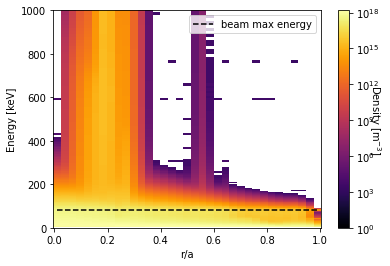

In [492]:
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('axes', titlesize = 10)
plt.rc('figure', titlesize = 10)
plt.rc('legend', fontsize = 10)
#"""
fig, ax = plt.subplots()
# pcm = ax.pcolormesh(energyCenters, rya, energeticDensity, 
#                 norm=colors.LogNorm(vmin=1, vmax=np.max(energeticDensity)),
#                 shading = 'nearest')
# print('---')
# print(rya.shape)
pcm = ax.pcolormesh(rya.T, energyCenters.T, energeticDensity.T, 
                norm=colors.LogNorm(vmin=1, vmax=np.max(energeticDensity.T)),
                shading = 'nearest', cmap='inferno')

cbar = fig.colorbar(pcm, ax=ax)#, extend='max')
cbar.set_label(r'Density [m$^{-3}$]', rotation=270)
ax.set_ylim([0,1000])
plt.savefig('heatmap.png')
plt.plot(rya, (rya/rya)*ebkev, 'k--', label='beam max energy')
plt.xlabel('r/a')
plt.ylabel('Energy [keV]')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Ion Density vs. Energy at r/a = 0.24059')

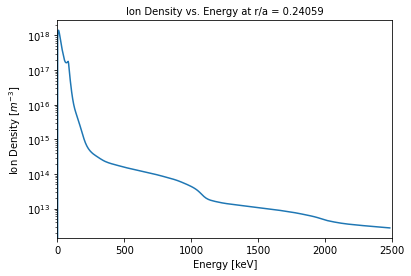

In [493]:
# Ion Density versus Energy at r/a = rya[i_rho]
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('axes', titlesize = 10)
plt.rc('figure', titlesize = 10)
plt.rc('legend', fontsize = 10)


max_energy_to_plot = 2500 # [keV]
i_max_E = np.argmin(np.abs(energyCenters - max_energy_to_plot))
energetic_particles_at_rho = energeticDensity[i_rho, :]
plt.yscale("log")
plt.plot(energyCenters[:i_max_E], energetic_particles_at_rho[:i_max_E])
plt.xlim([0, max_energy_to_plot])
plt.xlabel('Energy [keV]')
plt.ylabel(r'Ion Density [$m^{-3}$]')
plt.title(f'Ion Density vs. Energy at r/a = {rya[i_rho]}')


Text(0, 0.5, 'Ion Density for E_ion > 200 keV [$m^{-3}$]')

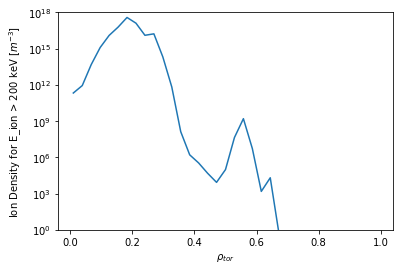

In [494]:
# Ion density versus r/a. Integrated over all energies. 

energeticDensity_1D = np.zeros(len(rya))
min_E = 200 # [keV] TODO: for now this must be larger than 2 KeV
E_idx = np.argmin(np.abs(min_E - enerkev))

#this is the radial part of the spherical jacobian
energeticDensity_1D = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,E_idx:]*relevantVels[E_idx:]**2,
    relevantVels[E_idx:]))

energeticDensity_1D = energeticDensity_1D*1e6 # convert to m^-3
plt.yscale('log')
plt.ylim([1e0, 1e18])
plt.plot(rya, energeticDensity_1D)
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(f'Ion Density for E_ion > {min_E} keV' + r' [$m^{-3}$]')


dict_keys(['version', 'mnemonic', 'ampfmod', 'urfmod', 'rdcmod', 'frmod', 'beamplse', 'transp', 'tavg', 'f4d_out', 'netcdfshort', 'eqdskin', 'ngen', 'ntotal', 'kspeci', 'bnumb', 'fmass', 'lrzmax', 'radcoord', 'rya', 'Rp', 'Rm', 'rhomax', 'radmaj', 'rpmconz', 'btor', 'toteqd', 'rgeomp', 'r0geomp', 'rmag', 'zmag', 'eqsym', 'zshift', 'eps0', 'elong', 'zgeomp', 'rgeom1', 'rgeom2', 'area', 'darea', 'vol', 'dvol', 'equilpsi', 'psivalm', 'dpsi', 'psimag', 'psilim', 'h_r', 'qsafety', 'curreq', 'lrz', 'lrindx', 'jx', 'x', 'enerkev', 'uoc', 'dx', 'cint2', 'vnorm', 'enorm', 'iy', 'y', 'dy', 'cynt2', 'iy_', 'itl', 'itu', 'lz', 'z', 'dz', 'solrz', 'solzz', 'pol', 'bbpsi', 'imax', 'lmax', 'zboun', 'zmaxpsi', 'tau', 'dtau', 'beampon', 'beampoff', 'tavg1', 'tavg2', 'ndeltarho', 'bthr', 'btoru', 'btor0', 'bmidplne', 'efflag', 'softxry', 'ipronn', 'gamafac', 'pellet', 'imp_type', 'nstates', 'fmass_imp', 'pellet_M0', 'pellet_Cablation', 'npa_diag', 'sigmamod', 'isigmas', 'mmsv', 'isigsgv1', 'isigsgv2', '

Text(0.5, 1.0, 'Total Absorbed RF power: 0.8982 MW')

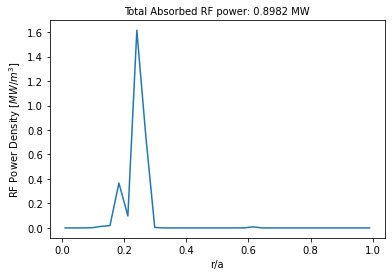

In [495]:
# Now want to do absorbed power partition 

print(cql_nc.variables.keys())
print(cqlrf_nc.variables.keys())

rf_power_density = cql_nc.variables["powrft"][-1]#convert to W/m^3
print(rf_power_density.shape)
plt.plot(rya, rf_power_density)
plt.xlabel('r/a')
plt.ylabel(r'RF Power Density [$MW/m^3$]')

dvol = cql_nc.variables['dvol'][:]

total_RF_power = np.trapz(rf_power_density*dvol)
#print(f'test: {sum(rf_power_density*dvol/1e6)}')
print(f'Total RF power: {round(total_RF_power)/1e6} MW')
plt.title(f'Total Absorbed RF power: {round(total_RF_power/1e6, 4)} MW')


0.0


Text(0.5, 1.0, 'Absorbed Power for Different Harmonics')

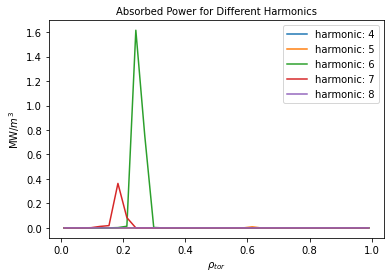

In [496]:
# RF power to mode l
powrf = cql_nc.variables['powrf'][:]
final_powrf = np.ma.getdata(powrf[-1, :, :])
final_powrf = final_powrf  # convert to MW 
print(max(final_powrf[5,:]))

num_harmonics_to_plot = 5
harm0 = 4 # the first harmonic: index 0 in num_harmonics is 4
for i in range(num_harmonics_to_plot):
    plt.plot(rya, final_powrf[i,:], label=f'harmonic: {i+harm0}')

plt.legend()
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'MW/$m^3$')
plt.title('Absorbed Power for Different Harmonics')

Total Fusion Power: 0.0
Total Fusion Power from File: 0.0


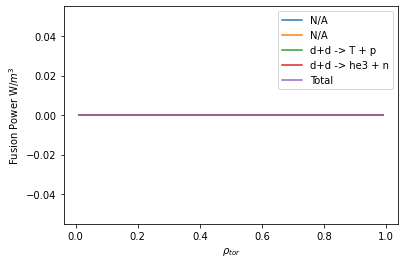

In [502]:
# fusion power plotting area 
fusion_power = cql_nc.variables['fuspwrv']
fusion_power = fusion_power[:, :]*1e6 #W/m^3
labels = ['N/A', 'N/A', 'd+d -> T + p', 'd+d -> he3 + n']
for i in range(fusion_power.shape[0]):
    plt.plot(rya, fusion_power[i, :], label=labels[i])

plt.ylabel(r'Fusion Power W/$m^3$')
plt.xlabel(r'$\rho_{tor}$')

fusion_power_rho_t = np.zeros_like(rya)
for i in range(fusion_power.shape[0]):
    fusion_power_rho_t = fusion_power_rho_t + fusion_power[i, :]
plt.plot(rya, fusion_power_rho_t, label='Total')
plt.legend()

sumed_fusion_power = np.trapz(fusion_power_rho_t*dvol) * (1/100)**3
print(f'Total Fusion Power: {sumed_fusion_power}')

total_fusion_power_from_file = sum(cql_nc.variables['fuspwrvt'][:])
print(f'Total Fusion Power from File: {total_fusion_power_from_file}')

The shape of powers is: (1, 13, 35)
The total RF power to the general species is 1.0152962637607217 MW
The total power to the maxw ion is -4.102247748415776 MW
The total power to the maxw e is -1.4622993453218898 MW
The total ion particle src power to gen is 8.70237764672307 MW


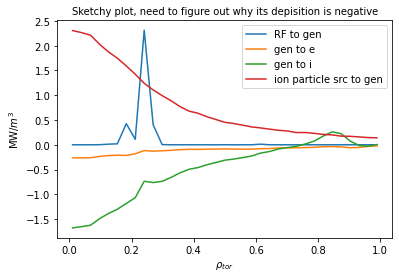

In [499]:
# Make plots of the way energy is partitioned to the main species.. seems sketchy 

powers = cql_nc.variables['powers'][-1, :, :, :]
print(f'The shape of powers is: {powers.shape}')
powers = powers[0, :, :]  # get the only general species
powers_RF_to_gen = powers[4, :]
powers_collisions_with_electrons = powers[0, :]
powers_collisions_with_ions = powers[1, :]
powers_ion_particle_source = powers[5, :]

plt.plot(rya, powers_RF_to_gen, label='RF to gen')
plt.plot(rya, powers_collisions_with_electrons, label='gen to e')
plt.plot(rya, powers_collisions_with_ions, label='gen to i')
plt.plot(rya, powers_ion_particle_source, label='ion particle src to gen')
plt.title('Sketchy plot, need to figure out why its depisition is negative')
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'MW/$m^3$')
plt.legend()
total_power_to_general = np.trapz((powers_RF_to_gen)*dvol*(1/100)**3)
total_power_to_max_ion = np.trapz((powers_collisions_with_ions)*dvol*(1/100)**3)
total_power_to_max_e = np.trapz((powers_collisions_with_electrons)*dvol*(1/100)**3)
total_power_ion_src = np.trapz((powers_ion_particle_source)*dvol*(1/100)**3)
print(f'The total RF power to the general species is {total_power_to_general} MW')
print(f'The total power to the maxw ion is {total_power_to_max_ion} MW')
print(f'The total power to the maxw e is {total_power_to_max_e} MW')
print(f'The total ion particle src power to gen is {total_power_ion_src} MW')

average SPA: 0.9957454019117294


0.9957454019117294

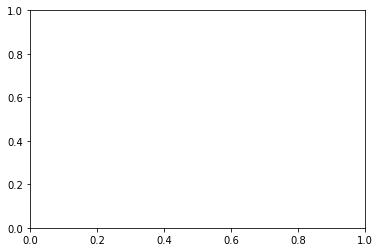

In [500]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from matplotlib.collections import LineCollection

# plt.rc('xtick', labelsize = 14)
# plt.rc('ytick', labelsize = 14)
# plt.rc('axes', labelsize = 16)
# plt.rc('axes', titlesize = 16)
# plt.rc('figure', titlesize = 18)
# plt.rc('legend', fontsize = 14)

# import os,sys
# currentdir = os.path.dirname(os.path.realpath(__file__))
# parentdir = os.path.dirname(currentdir)
# sys.path.append(parentdir)
# import getGfileDict
# gfileDict = getGfileDict.getGfileDict(pathprefix=f'{parentdir}/')

from scipy.signal import find_peaks

# import netCDF4
# cqlrf_nc = netCDF4.Dataset(f'{parentdir}/cql3d_krf001.nc','r')
# cql_nc = netCDF4.Dataset(f'{parentdir}/cql3d.nc','r')

def getSPA():
    """
    Finds single pass absorbtion using 
    1) energy at reflection point if ray is reflected
    2) assume all ray energy deposited if not reflected 
    Jacob fixed bug ignoring rays that did not reflect in SPA calculation 
    """
    radialVariable = (np.copy(cqlrf_nc.variables["spsi"]))
    delpwr= np.copy(cqlrf_nc.variables["delpwr"])


    #initialize SPA to zero. 
    averageSPA = 0
    bounceRho = .96  # if the ray turns after rho = 0.96, consider it reflected
   
    fig,ax = plt.subplots()
    offset = 1500     # reject turning points at eary times 
    ticker = 0
    for i in range(len(delpwr)):
        peakIndices, _ = find_peaks(radialVariable[i], height = bounceRho)
        relevantIndices = peakIndices[peakIndices > offset]
        
        #print(len(relevantIndices))
        if len(relevantIndices) > 0:
            bounceIndex = relevantIndices[0]
            SPA = 1-delpwr[i][bounceIndex]/delpwr[i][0]
            averageSPA += SPA
            ticker = ticker + 1 
        elif len(relevantIndices) == 0:
            SPA = 1
            averageSPA += SPA

    #print(f'ticker: {ticker}')  
    averageSPA /= len(delpwr)
    print(f"average SPA: {averageSPA}")
    return averageSPA
       
getSPA()

In [350]:
print(cql_nc.variables.keys())
delpwr = cqlrf_nc.variables['delpwr']
print(delpwr.shape)
print(len(delpwr))

dict_keys(['version', 'mnemonic', 'ampfmod', 'urfmod', 'rdcmod', 'frmod', 'beamplse', 'transp', 'tavg', 'f4d_out', 'netcdfshort', 'eqdskin', 'ngen', 'ntotal', 'kspeci', 'bnumb', 'fmass', 'lrzmax', 'radcoord', 'rya', 'Rp', 'Rm', 'rhomax', 'radmaj', 'rpmconz', 'btor', 'toteqd', 'rgeomp', 'r0geomp', 'rmag', 'zmag', 'eqsym', 'zshift', 'eps0', 'elong', 'zgeomp', 'rgeom1', 'rgeom2', 'area', 'darea', 'vol', 'dvol', 'equilpsi', 'psivalm', 'dpsi', 'psimag', 'psilim', 'h_r', 'qsafety', 'curreq', 'lrz', 'lrindx', 'jx', 'x', 'enerkev', 'uoc', 'dx', 'cint2', 'vnorm', 'enorm', 'iy', 'y', 'dy', 'cynt2', 'iy_', 'itl', 'itu', 'lz', 'z', 'dz', 'solrz', 'solzz', 'pol', 'bbpsi', 'imax', 'lmax', 'zboun', 'zmaxpsi', 'tau', 'dtau', 'beampon', 'beampoff', 'tavg1', 'tavg2', 'ndeltarho', 'bthr', 'btoru', 'btor0', 'bmidplne', 'efflag', 'softxry', 'ipronn', 'gamafac', 'pellet', 'imp_type', 'nstates', 'fmass_imp', 'pellet_M0', 'pellet_Cablation', 'npa_diag', 'sigmamod', 'isigmas', 'mmsv', 'isigsgv1', 'isigsgv2', '

0.9999999999999998


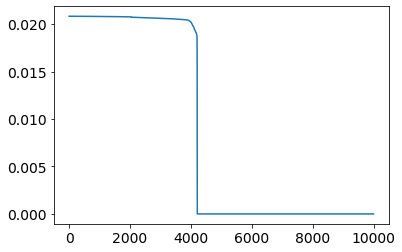

In [376]:
raynum = delpwr[1, :]
plt.plot(raynum*1e-7/1e6)
sum1 = 0
for i in range(len(delpwr)):
    pwr = delpwr[i, 0]
    sum1 = sum1 + pwr

sum1 = sum1*1e-7/1e6
print(sum1)

The total power to the ions is 0.0003950697730713917 W


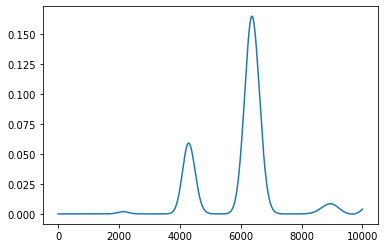

In [422]:
# grab the power to the ion 
sdpwr = cqlrf_nc.variables['sdpwr']
power_to_ions = 0
for i in range(len(sdpwr)):
    ray_i_power = sum(sdpwr[i, :])
    power_to_ions += ray_i_power

power_to_ions = power_to_ions * 1e-7 # convert to jouls
print(f'The total power to the ions is {power_to_ions} W')
plt.plot(sdpwr[0, :])